# $\epsilon$-Implicit Integrator

This notebook implements a **modified Leapfrog integrator**, commonly referred to as an **ε-implicit method**. Unlike the standard explicit Leapfrog scheme, this formulation allows controlled implicitness in the velocity update, improving numerical stability in the presence of dissipative or stiff forces (e.g. drag).

## Physical and Numerical Parameters

The simulation includes both physical constants and numerical control parameters:

- `t_stop`: Stopping (or coupling) time scale  
- `v_gas`: Background gas velocity  
- `M`: Mass of the central object  
- `G`: Gravitational constant (set to unity)  

This is the Kick-Drift-Kick equations of a leap-frog $\epsilon$-implicit integrator: 

$$\left[ {\begin{array}{c}
   x^{n+\frac{1}{2}}  \\
   y^{n+\frac{1}{2}}  \\
   z^{n+\frac{1}{2}}  \\
  \end{array} } \right] = \left[ {\begin{array}{c}
   x^{n}  \\
   y^{n}  \\
   z^{n}  \\
  \end{array} } \right] + \Delta t \left[ {\begin{array}{c}
   v^{n}_x  \\
   v^{n}_y  \\
   v^{n}_z  \\
  \end{array} } \right] \tag{1}$$

$$\left[ {\begin{array}{c}
   v^{n+1}_x \\
   v^{n+1}_y \\
   v^{n+1}_z  \\
  \end{array} } \right] = \left[ {\begin{array}{c}
   v^{n}_x  \\
   v^{n}_y  \\
   v^{n}_z  \\
  \end{array} } \right] + \Delta t \left[ {\begin{array}{ccc}
   \frac{1}{1-b\epsilon} & 0 & 0  \\
   0 & \frac{1}{1-b\epsilon} & 0   \\
   0 & 0 & \frac{1}{1-b\epsilon}  \\
  \end{array} } \right] \left[ {\begin{array}{c}
   \frac{GMx^{n+\frac{1}{2}}}{r^3} - \frac{v_n^x - v_g^x}{t^{n+\frac{1}{2}}_{stop}} \\
   \frac{GMy^{n+\frac{1}{2}}}{r^3} - \frac{v_n^y - v_g^y}{t^{n+\frac{1}{2}}_{stop}} \\
   \frac{GMz^{n+\frac{1}{2}}}{r^3} - \frac{v_n^z - v_g^z}{t^{n+\frac{1}{2}}_{stop}} \\
  \end{array} } \right] \tag{2}$$

$$\left[ {\begin{array}{c}
   x^{n+1}  \\
   y^{n+1}  \\
   z^{n+1}  \\
  \end{array} } \right] = \left[ {\begin{array}{c}
   x^{n+\frac{1}{2}} \\
 y^{n+\frac{1}{2}} \\
 z^{n+\frac{1}{2}}  \\
  \end{array} } \right] + \Delta t \left[ {\begin{array}{c}
   v^{n+1}_x  \\
   v^{n+1}_y  \\
   v^{n+1}_z  \\
  \end{array} } \right] \tag{3}$$

With $b = \frac{\Delta t}{t^{n+\frac{1}{2}}_{stop}}$

The parameter $\varepsilon$ controls how implicitly the dissipative term is treated.  
- $\varepsilon = 0$: fully explicit update  
- $\varepsilon \to 1$: increasingly implicit behavior  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Generating the Simulation time scales
dt = 0.1
t_max = 100
n_steps = int(t_max/dt)

#Generating the Particle Speed and Distance
v_x = np.zeros(n_steps)
v_y = np.zeros(n_steps)
v_z = np.zeros(n_steps)

x = np.zeros(n_steps)
y = np.zeros(n_steps)
z = np.zeros(n_steps)

time = np.zeros(n_steps)

#Starting Conditions of the Particle
v_x[0] = 156 #Intial Velocity
v_y[0] = 29 #Intial Velocity
v_z[0] = 3 #Intial Velocity

x[0] = 76  #Starting position
y[0] = 5  #Starting position
z[0] = 35  #Starting position


#Simulation constant
t_stop = 10 #Stopping Time
v_gas = 19.8 #Gas Velocity
M = 2       #Mass of central Object
G = 1

b = dt/(t_stop)
e = 0.90

#n-th velocity operator
c = (1)/(1-(b*e))

The example considered here corresponds to an idealized setup in which the gas velocity is assumed to be constant and the parameters of the central mass remain time-independent. However, as indicated by equation (2), a more general treatment requires evaluating the gas velocity and any time-dependent system parameters at the intermediate time level $t + \frac{\Delta t}{2}$. This midpoint evaluation is essential for maintaining the consistency and accuracy of the $\epsilon$-implicit integration scheme.

In [3]:
#Total Acceleration Calculator (Gravity + Drag)
def acceleration(x,y,z, v, unit):
    r = np.sqrt(x**2 + y**2 + z**2)
    if unit == 1:
        a_x_tot = (-(G*M*x)/r**3) - ((v - v_gas)/t_stop)
        return a_x_tot

    if unit == 2:
        a_y_tot = (-(G*M*y)/r**3) - ((v - v_gas)/t_stop)
        return a_y_tot

    if unit == 3:
        a_z_tot = (-(G*M*z)/r**3) - ((v - v_gas)/t_stop)
        return a_z_tot

In [4]:
#Leap Frog Loop
for i in range(1,n_steps):
    
#Half increment in position (kick):
    x_half = x[i-1] + (dt/2)*v_x[i-1]
    y_half = y[i-1] + (dt/2)*v_y[i-1]
    z_half = z[i-1] + (dt/2)*v_z[i-1]

#Full Increment in velocity (drift):
    a_x_new = acceleration(x_half, y_half, z_half, v_x[i-1], unit = 1)
    a_y_new = acceleration(x_half, y_half, z_half, v_y[i-1], unit = 2)
    a_z_new = acceleration(x_half, y_half, z_half, v_z[i-1], unit = 3)
    
    v_x[i] = v_x[i-1] + dt*c*a_x_new
    v_y[i] = v_y[i-1] + dt*c*a_y_new
    v_z[i] = v_z[i-1] + dt*c*a_z_new
    
#Full increment in position (kick):
    x[i] = x_half + (dt/2)*v_x[i]
    y[i] = y_half + (dt/2)*v_y[i]
    z[i] = z_half + (dt/2)*v_z[i]

#Time keeping
    time[i] = i*dt

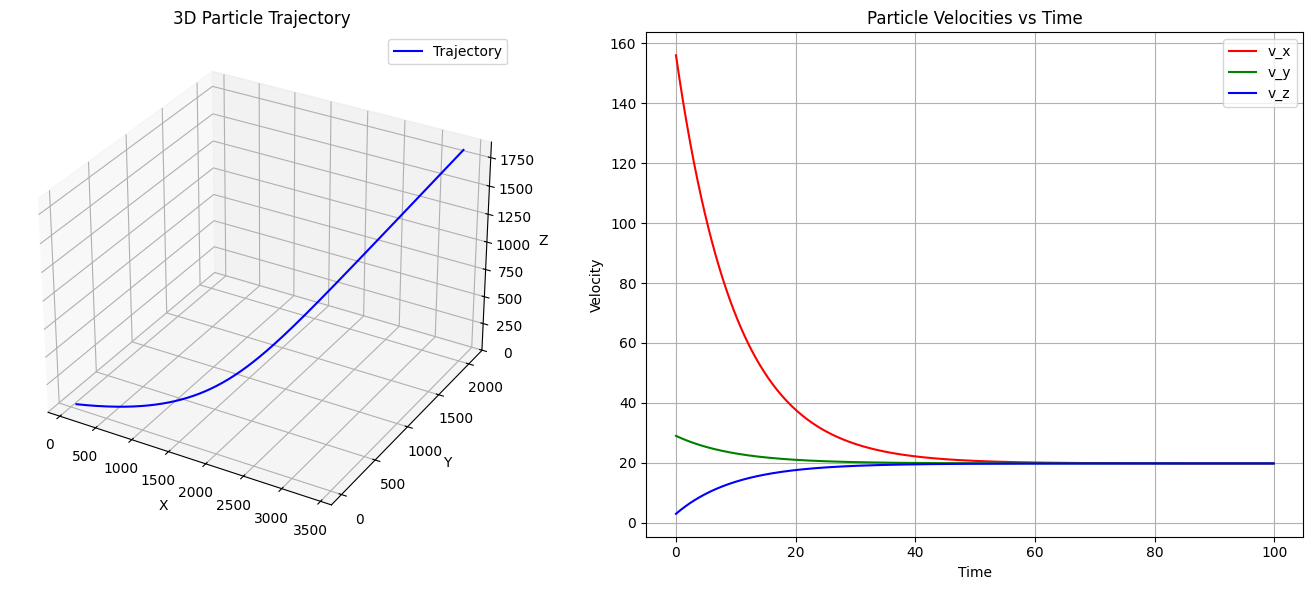

In [5]:
fig = plt.figure(figsize=(14,6))

# Left subplot: 3D trajectory
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(x, y, z, label='Trajectory', color='blue')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Particle Trajectory')
ax1.legend()

# Right subplot: velocities vs time
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(time, v_x, label='v_x', color='red')
ax2.plot(time, v_y, label='v_y', color='green')
ax2.plot(time, v_z, label='v_z', color='blue')
ax2.set_xlabel('Time')
ax2.set_ylabel('Velocity')
ax2.set_title('Particle Velocities vs Time')
ax2.legend()
ax2.grid(True)

# Show the combined figure
plt.tight_layout()
plt.show()